In [1]:
!pip install levenshtein

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.5/175.5 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 81.8 MB/s eta 0:00:00


### Trying out and some function definitions

In [2]:
from Levenshtein import distance, editops
import math
print(editops("这个苹果很酸", "居个苹果酸显酸"))
print(distance("这个苹果很酸", "居个苹果酸显酸"))

[('replace', 0, 0), ('insert', 4, 4), ('replace', 4, 5)]
3


In [3]:
# get normalized distance of two strings s1 and s2 by dividing their edit distance 
# by their maximum possible distance, aka the length of the longer string
def get_norm_distance(s1, s2):
  if len(s1) == 0 and len(s2) == 0:
    return 0
  else:
    return distance(s1, s2)/max(len(s1), len(s2))

# get edits details using the output of the function "editops" from Levenshtein package
def get_detailed_edits(s1, s2):
  adds, dels, subs = [], [], []
  edits = editops(s1, s2)
  for edit, pos1, pos2 in edits:  
    if edit == "replace":
      subs.append((s1[pos1], s2[pos2]))
    if edit == "delete":
      dels.append(s1[pos1])
    if edit == "insert":
      adds.append(s2[pos2])
  return {"insert":adds, "delete":dels, "substitute":subs}

In [4]:
get_norm_distance("这个苹果很酸", ""), get_norm_distance("这个苹果很酸", "这个苹果很酸")

(1.0, 0.0)

In [5]:
get_detailed_edits("该个苹果酸显酸", "这个苹果很酸")

{'insert': [], 'delete': ['显'], 'substitute': [('该', '这'), ('酸', '很')]}

### Read the data and get started

#### One sample

In [6]:
%cd drive/MyDrive/thesis
%ls

/content/drive/MyDrive/thesis
all_cmn_wuu_yue_sentences.csv
cc.zh.300.bin
cmn_vocab.csv
cmn_wen_1_gram.csv
cmn_wen_2_gram.csv
cmn_wen_3_gram.csv
cmn_wen_distance_scores.csv
cmn_wen_lv_distanceScores.csv
cmn_wen_lv_subs.csv
cmn_wen_ngrams.csv
cmn_wen_sbert_scores.csv
cmn_wen_sent_alignment.csv
cmn_wen_subs.csv
cmn_wuu_1_gram.csv
cmn_wuu_2_gram.csv
cmn_wuu_3_gram.csv
cmn_wuu_distance_scores.csv
cmn_wuu_lv_distanceScores.csv
cmn_wuu_lv_subs.csv
cmn_wuu_sbert_scores.csv
cmn_wuu_sent_alignment.csv
cmn_wuu_subs.csv
cmn_yue_1_gram.csv
cmn_yue_2_gram.csv
cmn_yue_3_gram.csv
cmn_yue_distance_scores.csv
cmn_yue_lv_distanceScores.csv
cmn_yue_lv_subs.csv
cmn_yue_sbert_scores.csv
cmn_yue_sent_alignment.csv
cmn_yue_subs.csv
cmn-yue-wuu-wen-parallel-simplified.csv
cmn-yue-wuu-wen-parallel-simplified_final.csv
mispredictions_in_1000_predictions.csv
sgns.merge.char
wen_vocab.csv
wen_wuu_sent_alignment.csv
wen_yue_1_gram.csv
wen_yue_2_gram.csv
wen_yue_3_gram.csv
wen_yue_distance_scores.csv
wen_yue_lv_dis

In [7]:
import pandas as pd

data = pd.read_csv("cmn-yue-wuu-wen-parallel-simplified_final.csv", encoding="utf-8")
data["cmn_sentence"]

0             我们试试看！
1              那又怎样?
2             不要说废话！
3            这个苹果很酸。
4        别忘了明天六时来接我。
           ...      
135          你们比我还高。
136             你好吗？
137     你们怎么就是没相信我呢？
138    他父母对他怀有过高的期望。
139            别倚着墙。
Name: cmn_sentence, Length: 140, dtype: object

In [8]:
from collections import Counter

def get_lang_sentDistances(langName1, langName2, to_csv=True):
  punc = ["。", "，", "！", "？", "'", "\"", ",", ".", "、", "?", "「", "」"]
  lang1 = data[langName1+"_sentence"]
  lang2 = data[langName2+"_sentence"]
  all_distances, all_detailed_edits = [], []
  for i in range(len(lang1)):
    # remove punctuations
    sent1 = "".join([c for c in lang1[i] if c not in punc])
    sent2 = "".join([c for c in lang2[i] if c not in punc])
    sentDis = get_norm_distance(sent1, sent2)
    all_distances.append((sent1, sent2, sentDis))
    all_detailed_edits.append(get_detailed_edits(sent1, sent2))
  if to_csv:
    all_subs = []
    for sent_edits in all_detailed_edits:
      all_subs += sent_edits["substitute"]
    subs_with_counts = [(item[0][0],item[0][1], item[1]) for item in Counter(all_subs).items()]
    df_subs = pd.DataFrame(data=subs_with_counts, columns=[langName1, langName2, "count"])
    df_scores = pd.DataFrame(data=all_distances, columns=[langName1, langName2, "LV distance score"])
    df_subs.to_csv(langName1+"_"+langName2+"_lv_subs.csv", encoding="utf-8")
    df_scores.to_csv(langName1+"_"+langName2+"_lv_distanceScores.csv", encoding="utf-8")
  return all_distances, all_detailed_edits

In [9]:
dis_cmn_wen, edits_cmn_wen = get_lang_sentDistances("cmn", "wen")
dis_cmn_wen

[('我们试试看', '卬你试试眙', 0.6),
 ('那又怎样', '那就訾那能爻', 0.8333333333333334),
 ('不要说废话', '覅讲废话', 0.6),
 ('这个苹果很酸', '居个苹果酸显酸', 0.42857142857142855),
 ('别忘了明天六时来接我', '覅悗记爻明朝六点钟走来接我', 0.6153846153846154),
 ('我相信他是个聪明人', '我相信渠是个聪明人', 0.1111111111111111),
 ('什么时候出发最方便你', '若能届走最方便啊你', 0.7),
 ('我永远不会忘记你', '我永远覅悗记你', 0.375),
 ('我打算把这块手表送给你', '我打算逮居个手表送匄你', 0.36363636363636365),
 ('这些书是谁的', '居厘书是何乜人个', 0.75),
 ('这条规则不是什么时候都适用的', '居条规定否是若能届沃可以用个', 0.7142857142857143),
 ('天气每天都在变', '天气每日沃是得变', 0.5),
 ('你应该先和你的父母谈谈', '你应该伉你爸妈谈一谈先', 0.6363636363636364),
 ('参加的人并不多', '参加个人否何乜多', 0.5),
 ('我们的结论就是那个传言是真的', '我厘个结论就是许个传言是真个', 0.2857142857142857),
 ('汤姆回乡下了', '汤姆走乡下转哦罢', 0.5),
 ('这些古老习俗都是一代一代相传下来的', '居厘老个习俗沃是一代一代传下个', 0.47058823529411764),
 ('她穿什么都好看', '渠着何乜沃好眙', 0.8571428571428571),
 ('房子一间一间地着了火', '屋宕一间一间能烧起', 0.6),
 ('她昨天为什么不来', '渠昨夜妆嚷冇走来', 0.75),
 ('他的房间除了一张桌子就什么也没有了', '渠个间里除爻一张桌就何乜沃冇', 0.7058823529411765),
 ('过了三天我才知道原来她失踪了', '过去三日我新晓得原来渠走狃宕爻罢', 0.6875),
 ('你什么时候回来', '你若能届走来', 0.7142857142857143),
 ('你懂得用这台相机吗

In [10]:
edits_cmn_wen

[{'insert': [],
  'delete': [],
  'substitute': [('我', '卬'), ('们', '你'), ('看', '眙')]},
 {'insert': ['就', '訾'],
  'delete': [],
  'substitute': [('又', '那'), ('怎', '能'), ('样', '爻')]},
 {'insert': [], 'delete': ['说'], 'substitute': [('不', '覅'), ('要', '讲')]},
 {'insert': ['酸'], 'delete': [], 'substitute': [('这', '居'), ('很', '显')]},
 {'insert': ['覅', '点', '钟'],
  'delete': [],
  'substitute': [('别', '悗'), ('忘', '记'), ('了', '爻'), ('天', '朝'), ('时', '走')]},
 {'insert': [], 'delete': [], 'substitute': [('他', '渠')]},
 {'insert': ['啊'],
  'delete': ['出', '发'],
  'substitute': [('什', '若'), ('么', '能'), ('时', '届'), ('候', '走')]},
 {'insert': [], 'delete': ['忘'], 'substitute': [('不', '覅'), ('会', '悗')]},
 {'insert': [],
  'delete': [],
  'substitute': [('把', '逮'), ('这', '居'), ('块', '个'), ('给', '匄')]},
 {'insert': ['何', '乜'],
  'delete': [],
  'substitute': [('这', '居'), ('些', '厘'), ('谁', '人'), ('的', '个')]},
 {'insert': [],
  'delete': [],
  'substitute': [('这', '居'),
   ('则', '定'),
   ('不', '否'),
   ('什

#### 1000 samples and plot

In [11]:
import numpy as np
import random
from statistics import stdev, mean, median
import seaborn as sns

def sampling(lang1_name, lang2_name, n=1000):
  all_avg_distances = []
  dis_details, _ = get_lang_sentDistances(lang1_name, lang2_name)
  for i in range(n):  
    sent_scores = random.choices([p[2] for p in dis_details], k=len(dis_details))
    avg_score = sum(sent_scores)/len(sent_scores)
    all_avg_distances.append(avg_score)
  return all_avg_distances

def plot(df, color=None, annotate_mean=True):
  # Calculating mean and standard deviation
  m, sd = 0, 0 
  ax = sns.kdeplot()
  t = 0
  for name in df.columns:
    md = median(df[name])
    mn = mean(df[name])
    sd = stdev(df[name])
    print("Language pair:", name[:3]+",", name[4:8])
    print("mean: ", mn, ";", "median: ", md, "standard deviation: ", sd)
    print("2u: ", md-2*sd, "-", md+2*sd)
    #ax = sns.histplot(df, stat="probability", kde=True, color=color) 
    if annotate_mean:
      ax.axvline(x=md, color="pink")
      t += 0.5
      ax.annotate(text="mean: "+str(round(mn,3)), xy=(mn+0.001,t))
    ax = sns.kdeplot(data=df, color=color, common_norm=True) #bw_adjust=.5) 
    ax.plot()

In [12]:
avg_disRatios_cmn_wen = sampling("cmn", "wen")
avg_disRatios_cmn_wuu = sampling("cmn", "wuu")
avg_disRatios_cmn_yue = sampling("cmn", "yue")
avg_disRatios_wuu_wen = sampling("wuu", "wen")
avg_disRatios_wuu_yue = sampling("wuu", "yue")
avg_disRatios_wen_yue = sampling("wen", "yue")
avg_disRatios_cmn_wen

[0.5195818533523089,
 0.4893013839384358,
 0.5130038845374981,
 0.5347708821290753,
 0.5303539330098376,
 0.5464166939318973,
 0.5449023261617245,
 0.5349495814458772,
 0.5433846891719514,
 0.5309753196150252,
 0.5265070039486782,
 0.5460555008716773,
 0.48997872983692303,
 0.5375403984437598,
 0.5282415899742308,
 0.5226542874541545,
 0.5202432356208339,
 0.5115269458599289,
 0.5155838627623787,
 0.520047649442552,
 0.5520198656385625,
 0.5481274141358176,
 0.5410061194456927,
 0.526533921843796,
 0.5565039374540148,
 0.5295628154341111,
 0.5293083605052866,
 0.5535522355795465,
 0.5148014614384585,
 0.5309731584941672,
 0.5397909192814655,
 0.5239931905162997,
 0.5316764040912647,
 0.5520400631728585,
 0.5461534882018075,
 0.5153897303308512,
 0.5461783365658863,
 0.5158030539537616,
 0.5197341901427484,
 0.5336125273934873,
 0.5512790128319762,
 0.545487918943801,
 0.5583652315054352,
 0.5491613967081125,
 0.5218207539426024,
 0.5221731435796008,
 0.5467714716238601,
 0.524930154309

In [13]:
stack = np.stack((np.array(avg_disRatios_cmn_wen),np.array(avg_disRatios_cmn_wuu), np.array(avg_disRatios_cmn_yue),
                  np.array(avg_disRatios_wuu_wen), np.array(avg_disRatios_wuu_yue), np.array(avg_disRatios_wen_yue)), axis=1)
all_df = pd.DataFrame(stack, columns=["cmn_wen", "cmn_wuu", "cmn_yue", "wuu_wen", "wuu_yue", "wen_yue"])

Language pair: cmn, wen
mean:  0.5324449297755846 ; median:  0.5320092031567871 standard deviation:  0.016462094120023727
2u:  0.4990850149167397 - 0.5649333913968346
Language pair: cmn, wuu
mean:  0.5161826157377747 ; median:  0.5157416892502309 standard deviation:  0.019068869750316728
2u:  0.4776039497495974 - 0.5538794287508644
Language pair: cmn, yue
mean:  0.6529985271601798 ; median:  0.6538494056409425 standard deviation:  0.017360207996857464
2u:  0.6191289896472276 - 0.6885698216346574
Language pair: wuu, wen
mean:  0.5898524149200356 ; median:  0.5898649232723774 standard deviation:  0.018602008084680866
2u:  0.5526609071030156 - 0.6270689394417391
Language pair: wuu, yue
mean:  0.7134088850901334 ; median:  0.7129343507502124 standard deviation:  0.016390898147157155
2u:  0.6801525544558981 - 0.7457161470445267
Language pair: wen, yue
mean:  0.7001256683554643 ; median:  0.700508340193785 standard deviation:  0.016116293064876747
2u:  0.6682757540640316 - 0.7327409263235385

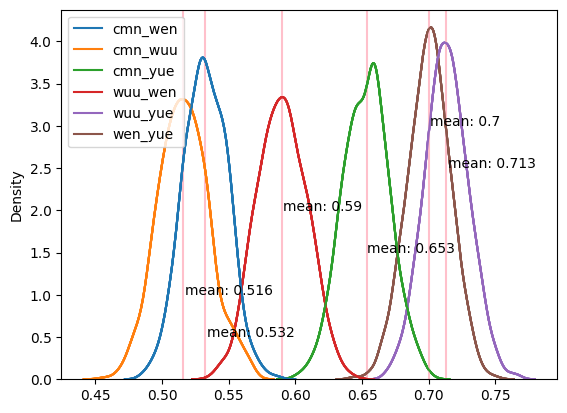

In [14]:
plot(all_df)